In [ ]:
import csv
import numpy as np
import pandas as pd

np.random.seed(0)

# Chargement du dataset existant
df = pd.read_csv('donnees_sante.csv')

# Calcul du nombre de records à supprimer
n_samples = len(df)
n_labels_to_remove = int(0.6 * n_samples)
n_labels_to_remove_normal = int(0.3 * n_labels_to_remove)
n_labels_to_remove_critical = n_labels_to_remove - n_labels_to_remove_normal

# Sélection aléatoire des indices des labels à supprimer de classe "Normal"
indices_normal = df[df['Class'] == 'Normal'].index
indices_to_remove_normal = np.random.choice(indices_normal, size=n_labels_to_remove_normal, replace=False)

# Sélection aléatoire des indices des labels à supprimer de classe "Critical"
indices_critical = df[df['Class'] == 'Critical'].index
indices_to_remove_critical = np.random.choice(indices_critical, size=n_labels_to_remove_critical, replace=False)

# Fusion des indices à supprimer
indices_to_remove = np.concatenate((indices_to_remove_normal, indices_to_remove_critical))

# Suppression des labels correspondants
df.loc[indices_to_remove, 'Class'] = ''

# Chemin du fichier CSV de sortie
output_file = 'nouveau_dataset.csv'

# Écriture du nouveau dataset dans un fichier CSV
df.to_csv(output_file, index=False)

# Affichage des données générées
print(df.to_string(index=False))

# Calcul du nombre de records avec labels
n_records_with_labels = df[df['Class'] != ''].shape[0]

# Calcul du nombre de records sans labels
n_records_without_labels = df[df['Class'] == ''].shape[0]

# Affichage du nombre de records avec labels et sans labels
print("Nombre de records avec labels : ", n_records_with_labels)
print("Nombre de records sans labels : ", n_records_without_labels)



 SP02  BP Systolic  BP Diastolic  HR  Pulse  Temperature    Class
   91          123            70 102     17         37.3   Normal
   99          108            85  91     12         36.8         
   89          149            91 191     29         40.5 Critical
   93          103            73  78     19         36.6   Normal
   82          146            94 186     23         39.9         
   81          145            90 169     29         39.7         
   99          133            84 103     19         37.5   Normal
   93          129            77  73     16         36.1         
   92          107            70  60     12         37.4         
   90          115            88  63     12         36.5         
   98          118            81  86     14         36.0         
   97          127            70  83     12         37.3         
   95          120            75  87     13         36.8   Normal
   97          130            86  96     16         36.4         
  100     

# Nouvelle section

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Record 1 - Predicted Label: Normal
Record 2 - Predicted Label: Critical
Record 3 - Predicted Label: Critical
Record 4 - Predicted Label: Normal
Record 5 - Predicted Label: Normal
Record 6 - Predicted Label: Normal
Record 7 - Predicted Label: Normal
Record 8 - Predicted Label: Critical
Record 9 - Predicted Label: Critical
Record 10 - Predicted Label: Critical
Record 11 - Predicted Label: Critical
Record 12 - Predicted Label: Critical
Record 13 - Predicted Label: Normal
Record 14 - Predicted Label: Critical
Record 15 - Predicted Label: Critical
Record 16 - Predicted Label: Normal
Record 17 - Predicted Label: Normal
Record 18 - Predicted Label: Critical
Record 19 - Predicted Label: Normal
Record 20 - Predicted Label: Critical
Record 21 - Predicted Label: Critical
Record 22 - Predicted Label: Critical
Record 23 - Predicted Label: Normal
Record 24 - Predicted Label: Critical
Record 25 - Predicted Label: Critical
Record 26 - Predicted Label: Normal
Record 27 - Predicted Label: Normal
Record 

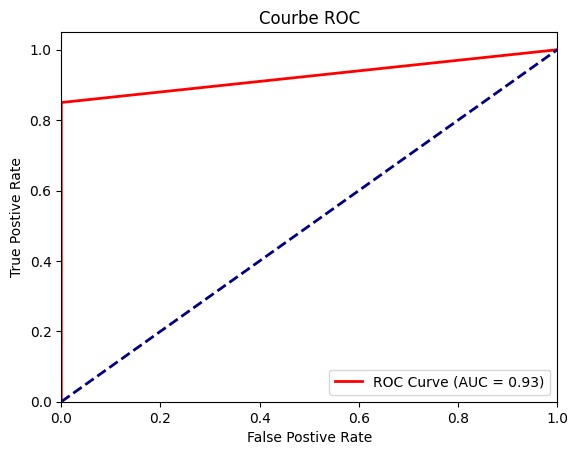

              precision    recall  f1-score   support

    Critical       0.91      1.00      0.95       600
      Normal       1.00      0.85      0.92       400

    accuracy                           0.94      1000
   macro avg       0.95      0.93      0.94      1000
weighted avg       0.95      0.94      0.94      1000



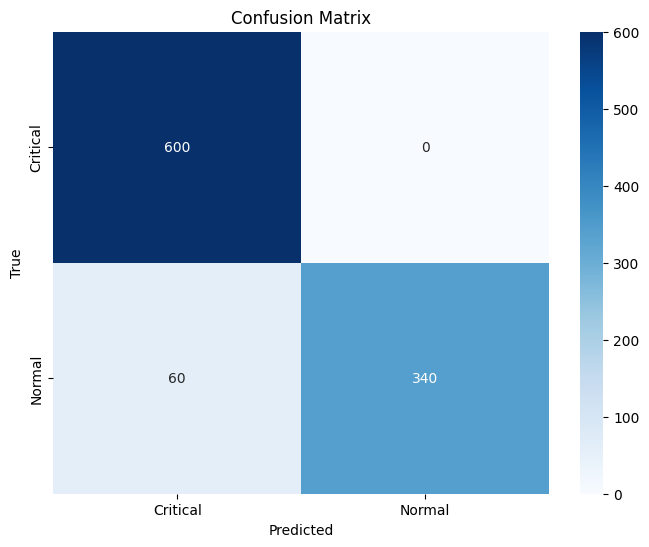

In [ ]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


# Chargement du dataset
dataset = pd.read_csv('nouveau_dataset.csv')

# Séparation des données et des classes
X_labeled = dataset[~dataset['Class'].isnull()].drop('Class', axis=1)
X_unlabeled = dataset[dataset['Class'].isnull()].drop('Class', axis=1)
y_labeled = dataset[~dataset['Class'].isnull()]['Class']

# Conversion des classes en valeurs numériques
label_map = {'Critical': 0, 'Normal': 1}
y_numeric = np.array([label_map[label] for label in y_labeled])

# Création du modèle de propagation de labels
model = LabelPropagation()

# Entraînement du modèle sur les données étiquetées
model.fit(X_labeled, y_numeric)

# Prédiction des classes pour les données non étiquetées
y_pred = model.predict(X_unlabeled)

# Remplacement des valeurs numériques par les étiquettes originales
y_pred_labels = np.array(['Critical' if label == 0 else 'Normal' for label in y_pred])

# Mise à jour du dataset avec les classes prédites
dataset.loc[dataset['Class'].isnull(), 'Class'] = y_pred_labels

# Affichage des prédictions de labels pour les données non étiquetées
for i, label in enumerate(y_pred_labels):
    print(f"Record {i+1} - Predicted Label: {label}")

# Chargement du dataset initial avec les classes réelles
dataset_initial = pd.read_csv('donnees_sante.csv')

# Extraction des classes réelles du dataset initial
y_true = dataset_initial['Class'].values

# Extraction des classes prédites du nouveau dataset
y_pred = dataset['Class'].values

# Conversion des étiquettes en valeurs binaires
y_true_binary = label_binarize(y_true, classes=['Critical', 'Normal'])
y_pred_binary = label_binarize(y_pred, classes=['Critical', 'Normal'])

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(y_true_binary.ravel(), y_pred_binary.ravel())
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Calcul des métriques de classification
classification_metrics = classification_report(y_true, y_pred)
print(classification_metrics)

# Sauvegarde du dataset mis à jour
dataset.to_csv('Predictions-semi-supervise.csv', index=False)

from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
confusion = confusion_matrix(y_true, y_pred, labels=['Critical', 'Normal'])

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Critical', 'Normal'], yticklabels=['Critical', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Chargement du dataset
dataset = pd.read_csv('nouveau_dataset.csv')

# Séparation des données et des classes
X_labeled = dataset[~dataset['Class'].isnull()].drop('Class', axis=1)
X_unlabeled = dataset[dataset['Class'].isnull()].drop('Class', axis=1)
y_labeled = dataset[~dataset['Class'].isnull()]['Class']

# Conversion des classes en valeurs numériques
label_map = {'Critical': 0, 'Normal': 1}
y_numeric = np.array([label_map[label] for label in y_labeled])

# Création du modèle de propagation de labels
model = LabelPropagation()

# Entraînement du modèle sur les données étiquetées
model.fit(X_labeled, y_numeric)

# Prédiction des classes pour les données non étiquetées
y_pred = model.predict(X_unlabeled)

# Remplacement des valeurs numériques par les étiquettes originales
y_pred_labels = np.array(['Critical' if label == 0 else 'Normal' for label in y_pred])

# Mise à jour du dataset avec les classes prédites
dataset.loc[dataset['Class'].isnull(), 'Class'] = y_pred_labels

# Affichage des prédictions de labels pour les données non étiquetées
for i, label in enumerate(y_pred_labels):
    print(f"Record {i+1} - Predicted Label: {label}")

# Chargement du dataset initial avec les classes réelles
dataset_initial = pd.read_csv('test_initial.csv')

# Extraction des classes réelles du dataset initial
y_true = dataset_initial['Class'].values

# Extraction des classes prédites du nouveau dataset
y_pred = dataset['Class'].values

# Conversion des étiquettes en valeurs binaires
y_true_binary = label_binarize(y_true, classes=['Critical', 'Normal'])
y_pred_binary = label_binarize(y_pred, classes=['Critical', 'Normal'])

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(y_true_binary.ravel(), y_pred_binary.ravel())
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Calcul des métriques de classification
classification_metrics = classification_report(y_true, y_pred)
print(classification_metrics)

# Sauvegarde du dataset mis à jour
dataset.to_csv('Predictions-semi-supervise.csv', index=False)

# Création du fichier comparaison.csv
comparison_df = pd.DataFrame({'Classe_Réelle': y_true, 'Classe_Prédite': y_pred})
comparison_df.to_csv('comparaison.csv', index=False)


Record 1 - Predicted Label: Normal
Record 2 - Predicted Label: Critical
Record 3 - Predicted Label: Critical
Record 4 - Predicted Label: Normal
Record 5 - Predicted Label: Normal
Record 6 - Predicted Label: Normal
Record 7 - Predicted Label: Normal
Record 8 - Predicted Label: Critical
Record 9 - Predicted Label: Critical
Record 10 - Predicted Label: Critical
Record 11 - Predicted Label: Critical
Record 12 - Predicted Label: Critical
Record 13 - Predicted Label: Normal
Record 14 - Predicted Label: Critical
Record 15 - Predicted Label: Critical
Record 16 - Predicted Label: Normal
Record 17 - Predicted Label: Normal
Record 18 - Predicted Label: Critical
Record 19 - Predicted Label: Normal
Record 20 - Predicted Label: Critical
Record 21 - Predicted Label: Critical
Record 22 - Predicted Label: Critical
Record 23 - Predicted Label: Normal
Record 24 - Predicted Label: Critical
Record 25 - Predicted Label: Critical
Record 26 - Predicted Label: Normal
Record 27 - Predicted Label: Normal
Record 

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


ValueError: ignored

In [ ]:
import pandas as pd

# Chargement des fichiers
dataset_original = pd.read_csv('donnees_sante.csv')
dataset_semi_supervise = pd.read_csv('nouveau_dataset.csv')
predictions_semi_supervise = pd.read_csv('Predictions-semi-supervise.csv')

# Division du fichier 'donnees_sante.csv' en train_initial et test_initial
train_initial = dataset_original.sample(frac=0.8, random_state=42)
test_initial = dataset_original.drop(train_initial.index)

train_semi_supervise = dataset_semi_supervise.sample(frac=0.8, random_state=42)
test_semi_supervise = dataset_semi_supervise.drop(train_initial.index)

train_predictions = predictions_semi_supervise.sample(frac=0.8, random_state=42)
test_predictions = predictions_semi_supervise.drop(train_predictions.index)

# Sauvegarde des fichiers train_initial.csv et test_initial.csv
train_initial.to_csv('train_initial.csv', index=False)
test_initial.to_csv('test_initial.csv', index=False)

train_semi_supervise.to_csv('train_semi_supervise.csv',index=False)
test_semi_supervise.to_csv('test_semi_supervise.csv',index=False)

# Sauvegarde du fichier train_predictions.csv
train_predictions.to_csv('train_predictions.csv', index=False)

# Suppression de la colonne 'classe' du fichier test_predictions
test_predictions_without_class = test_predictions.iloc[:, :-1]

# Sauvegarde du fichier test_predictions.csv sans la colonne 'classe'
test_predictions_without_class.to_csv('test_predictions.csv', index=False)

# Affichage du nombre de lignes de chaque fichier
print("Nombre de lignes dans train_initial.csv :", len(train_initial))
print("Nombre de lignes dans test_initial.csv :", len(test_initial))
print("Nombre de lignes dans train_predictions.csv :", len(train_predictions))
print("Nombre de lignes dans test_predictions.csv :", len(test_predictions_without_class))


Nombre de lignes dans train_initial.csv : 800
Nombre de lignes dans test_initial.csv : 200
Nombre de lignes dans train_predictions.csv : 800
Nombre de lignes dans test_predictions.csv : 200


In [ ]:
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Chargement des données d'entraînement
train_data = pd.read_csv("train_predictions.csv")

# Séparation des features (X) et de la variable cible (y)
X_train = train_data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
y_train = train_data.iloc[:, -1]  # Dernière colonne

# Entraînement du modèle SARSA
sarsa_model = SGDClassifier(loss='log')
sarsa_model.fit(X_train, y_train)

# Chargement des données de test
test_data = pd.read_csv("test_semi_supervise.csv")
X_test = test_data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière

# Prédiction des classes pour les données de test
predicted_classes = sarsa_model.predict(X_test)

# Création d'un nouveau dataframe avec les prédictions
sarsa_predictions = pd.DataFrame({
    "Classe Prédite": predicted_classes
})

SARSA_vs_Label_propagation = pd.DataFrame({
    "Prédictions SARSA        |": predicted_classes
})

# Chargement des données réelles pour comparaison
actual_data = pd.read_csv("test_initial.csv")

# Extraction des classes réelles
y_actual = actual_data.iloc[:, -1]

#chargement des données prédites du semi-supervisé pour comparaison
Label_propagation_data=pd.read_csv("test_predictions.csv")

#Extraction des données prédites de Label Propagation
y_semi = Label_propagation_data.iloc[:, -1]

# Ajout de la colonne des classes réelles dans le dataframe des prédictions
sarsa_predictions["Classe Réelle"] = y_actual

# Ajout de la colonne des classes prédites par Label Propagation
SARSA_vs_Label_propagation["Prédictions Label Propagation"] = y_semi

# Affichage des classes prédites et réelles côte à côte
print(sarsa_predictions)

# Encodage des classes réelles en valeurs numériques catégorielles
label_encoder = LabelEncoder()
y_actual_encoded = label_encoder.fit_transform(y_actual)
y_predicted_encoded = label_encoder.transform(predicted_classes)

# Calcul de la précision
accuracy = accuracy_score(y_actual_encoded, y_predicted_encoded)
print("Précision : ", accuracy)

# Calcul du rappel
recall = recall_score(y_actual_encoded, y_predicted_encoded, average='macro')
print("Rappel : ", recall)

# Calcul du score F1
f1 = f1_score(y_actual_encoded, y_predicted_encoded, average='macro')
print("Score F1 : ", f1)

# Calcul du taux d'erreur
error_rate = 1 - accuracy
print("Taux d'erreur : ", error_rate)

# Calcul de la courbe ROC (stratégie "ovo")
roc_auc = roc_auc_score(y_actual_encoded, sarsa_model.decision_function(X_test), multi_class='ovo')
print("Courbe ROC : ", roc_auc)



    Classe Prédite Classe Réelle
0           Normal        Normal
1         Critical      Critical
2           Normal        Normal
3           Normal        Normal
4         Critical      Critical
..             ...           ...
195       Critical      Critical
196       Critical      Critical
197         Normal        Normal
198       Critical      Critical
199         Normal        Normal

[200 rows x 2 columns]
Précision :  1.0
Rappel :  1.0
Score F1 :  1.0
Taux d'erreur :  0.0
Courbe ROC :  1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


# Nouvelle section

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data = pd.read_csv('test_semi_supervise.csv')
test_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1).values
y_train = (train_data['Class'] == 'Critical').astype(int).values
X_test = test_data.drop('Class', axis=1).values
y_test = (test_initial['Class'] == 'Critical').astype(int).values

# Algorithme SARSA simplifié (juste pour démonstration)
def sarsa(X_train, y_train, X_test):
    num_states = X_train.shape[0]
    num_actions = 2  # (0: Normal, 1: Critical)

    Q = np.zeros((num_states, num_actions))

    alpha = 0.9  # Taux d'apprentissage
    gamma = 0.9  # Facteur d'actualisation
    epsilon = 0.9  # Probabilité d'exploration

    for episode in range(100):  # Nombre d'épisodes d'apprentissage
        for state in range(num_states):
            action = np.argmax(Q[state])
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)

            reward = y_train[state]
            next_state = state + 1 if state + 1 < num_states else state
            next_action = np.argmax(Q[next_state])

            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

    # Prédiction sur les données de test
    y_pred = []
    for state in range(X_test.shape[0]):
        action = np.argmax(Q[state])
        y_pred.append(action)

    return np.array(y_pred)

# Prédiction avec SARSA
y_pred_sarsa = sarsa(X_train, y_train, X_test)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred_sarsa)

# Affichage de la précision
print("Accuracy:", accuracy)


Accuracy: 0.5


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data = pd.read_csv('test_semi_supervise.csv')
test_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1).values
y_train = (train_data['Class'] == 'Critical').astype(int).values
X_test = test_data.drop('Class', axis=1).values
y_test = (test_initial['Class'] == 'Critical').astype(int).values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Algorithme Q-learning simplifié (juste pour démonstration)
def q_learning(X_train, y_train, X_test):
    num_states = X_train.shape[0]
    num_actions = 2  # (0: Normal, 1: Critical)

    Q = np.zeros((num_states, num_actions))

    alpha = 0.9  # Taux d'apprentissage
    gamma = 0.9  # Facteur d'actualisation
    epsilon = 0.1  # Probabilité d'exploration

    for episode in range(100):  # Nombre d'épisodes d'apprentissage
        for state in range(num_states):
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(Q[state])

            reward = y_train[state]
            next_state = state + 1 if state + 1 < num_states else state
            max_next_action = np.argmax(Q[next_state])

            Q[state][action] += alpha * (reward + gamma * Q[next_state][max_next_action] - Q[state][action])

    # Prédiction sur les données de test
    y_pred = []
    for state in range(X_test.shape[0]):
        action = np.argmax(Q[state])
        y_pred.append(action)

    return np.array(y_pred)

# Prédiction avec Q-learning
y_pred_q_learning = q_learning(X_train_scaled, y_train, X_test_scaled)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred_q_learning)

# Affichage de l'accuracy
print("Accuracy:", accuracy)


Accuracy: 0.49


Accuracy: 0.5


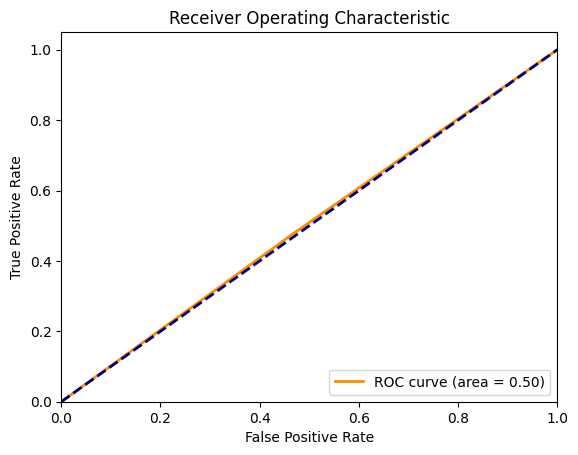

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data = pd.read_csv('test_semi_supervise.csv')
test_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1).values
y_train = (train_data['Class'] == 'Critical').astype(int).values
X_test = test_data.drop('Class', axis=1).values
y_test = (test_initial['Class'] == 'Critical').astype(int).values

# Algorithme SARSA simplifié (juste pour démonstration)
def sarsa(X_train, y_train, X_test):
    num_states = X_train.shape[0]
    num_actions = 2  # (0: Normal, 1: Critical)

    Q = np.zeros((num_states, num_actions))

    alpha = 0.9  # Taux d'apprentissage
    gamma = 0.9  # Facteur d'actualisation
    epsilon = 0.9  # Probabilité d'exploration

    for episode in range(100):  # Nombre d'épisodes d'apprentissage
        for state in range(num_states):
            action = np.argmax(Q[state])
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)

            reward = y_train[state]
            next_state = state + 1 if state + 1 < num_states else state
            next_action = np.argmax(Q[next_state])

            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

    # Prédiction sur les données de test
    y_pred = []
    for state in range(X_test.shape[0]):
        action = np.argmax(Q[state])
        y_pred.append(action)

    return np.array(y_pred)

# Prédiction avec SARSA
y_pred_sarsa = sarsa(X_train, y_train, X_test)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred_sarsa)

# Calcul des probabilités pour la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_sarsa)
roc_auc = auc(fpr, tpr)

# Affichage de la précision
print("Accuracy:", accuracy)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import gym

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data = pd.read_csv('test_semi_supervise.csv')
test_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1).values
y_train = (train_data['Class'] == 'Critical').astype(int).values
X_test = test_data.drop('Class', axis=1).values
y_test = (test_initial['Class'] == 'Critical').astype(int).values

# Algorithme Q-learning simplifié avec OpenAI Gym
class CustomEnv(gym.Env):
    def __init__(self, X_train, y_train):
        super(CustomEnv, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_states = X_train.shape[0]
        self.num_actions = 2  # (0: Normal, 1: Critical)
        self.current_state = 0
        self.action_space = gym.spaces.Discrete(self.num_actions)
        self.observation_space = gym.spaces.Discrete(self.num_states)

    def reset(self):
        self.current_state = 0
        return self.current_state

    def step(self, action):
        reward = self.y_train[self.current_state]
        next_state = self.current_state + 1 if self.current_state + 1 < self.num_states else self.current_state
        done = self.current_state == self.num_states - 1
        self.current_state = next_state
        return next_state, reward, done, {}

# Environnement personnalisé
env = CustomEnv(X_train, y_train)

# Algorithme Q-learning
def q_learning(env, num_episodes=100, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_table = np.zeros((env.num_states, env.num_actions))

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, _ = env.step(action)
            max_next_action = np.argmax(q_table[next_state])

            q_table[state][action] += alpha * (reward + gamma * q_table[next_state][max_next_action] - q_table[state][action])
            state = next_state

    return q_table

# Entraînement du modèle Q-learning
q_table = q_learning(env)

# Prédiction sur les données de test
y_pred = []
state = 0
for _ in range(X_test.shape[0]):
    action = np.argmax(q_table[state])
    y_pred.append(action)
    state = state + 1 if state + 1 < env.num_states else state

# Calcul de l'accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)

# Affichage de l'accuracy
print("Accuracy:", accuracy)


Accuracy: 0.44


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data = pd.read_csv('test_semi_supervise.csv')
test_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1)
y_train = train_data['Class']
X_test = test_data.drop('Class', axis=1)
y_test = test_initial['Class']

# Entraînement du modèle de forêt aléatoire
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = model.predict(X_test)

# Calcul des métriques de performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Critical')
recall = recall_score(y_test, y_pred, pos_label='Critical')
f1 = f1_score(y_test, y_pred, pos_label='Critical')

# Affichage des performances
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)



Accuracy: 0.98
Precision: 0.967479674796748
Recall: 1.0
F1-Score: 0.9834710743801653


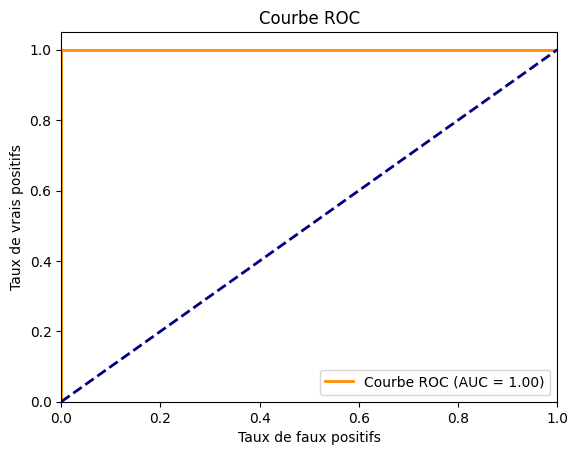

Accuracy: 0.985
Precision: 0.9754098360655737
Recall: 1.0
F1-Score: 0.9875518672199171


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data = pd.read_csv('test_semi_supervise.csv')
test_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1)
y_train = (train_data['Class'] == 'Critical').astype(int)
X_test = test_data.drop('Class', axis=1)
y_test = (test_initial['Class'] == 'Critical').astype(int)

# Entraînement du modèle de forêt aléatoire
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédiction des probabilités pour la classe positive
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Rate of False Positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Prédiction sur les données de test
y_pred = model.predict(X_test)

# Calcul des métriques de performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Affichage des performances
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data = pd.read_csv('test_semi_supervise.csv')
test_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1).values
y_train = (train_data['Class'] == 'Critical').astype(int).values
X_test = test_data.drop('Class', axis=1).values
y_test = (test_initial['Class'] == 'Critical').astype(int).values

# Algorithme Q-learning simplifié (juste pour démonstration)
def q_learning(X_train, y_train, X_test):
    num_states = X_train.shape[0]
    num_actions = 2  # (0: Normal, 1: Critical)

    Q = np.zeros((num_states, num_actions))

    alpha = 0.9  # Taux d'apprentissage
    gamma = 0.9  # Facteur d'actualisation
    epsilon = 0.1  # Probabilité d'exploration

    for episode in range(100):  # Nombre d'épisodes d'apprentissage
        for state in range(num_states):
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(Q[state])

            reward = y_train[state]
            next_state = state + 1 if state + 1 < num_states else state
            max_next_action = np.argmax(Q[next_state])

            Q[state][action] += alpha * (reward + gamma * Q[next_state][max_next_action] - Q[state][action])

    # Prédiction sur les données de test
    y_pred = []
    for state in range(X_test.shape[0]):
        action = np.argmax(Q[state])
        y_pred.append(action)

    return np.array(y_pred)

# Prédiction avec Q-learning
y_pred_q_learning = q_learning(X_train, y_train, X_test)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred_q_learning)

# Affichage de l'accuracy
print("Accuracy:", accuracy)


Accuracy: 0.49


Accuracy: 0.49


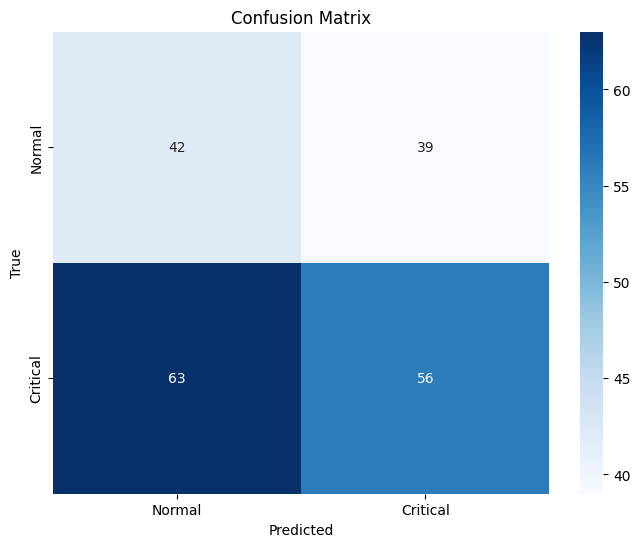

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data = pd.read_csv('test_semi_supervise.csv')
test_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1).values
y_train = (train_data['Class'] == 'Critical').astype(int).values
X_test = test_data.drop('Class', axis=1).values
y_test = (test_initial['Class'] == 'Critical').astype(int).values

# Algorithme Q-learning simplifié (juste pour démonstration)
def q_learning(X_train, y_train, X_test):
    num_states = X_train.shape[0]
    num_actions = 2  # (0: Normal, 1: Critical)

    Q = np.zeros((num_states, num_actions))

    alpha = 0.9  # Taux d'apprentissage
    gamma = 0.9  # Facteur d'actualisation
    epsilon = 0.9  # Probabilité d'exploration

    for episode in range(100):  # Nombre d'épisodes d'apprentissage
        for state in range(num_states):
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(Q[state])

            reward = y_train[state]
            next_state = state + 1 if state + 1 < num_states else state
            max_next_action = np.argmax(Q[next_state])

            Q[state][action] += alpha * (reward + gamma * Q[next_state][max_next_action] - Q[state][action])

    # Prédiction sur les données de test
    y_pred = []
    for state in range(X_test.shape[0]):
        action = np.argmax(Q[state])
        y_pred.append(action)

    return np.array(y_pred)

# Prédiction avec Q-learning
y_pred_q_learning = q_learning(X_train, y_train, X_test)

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred_q_learning)
print("Accuracy:", accuracy)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_q_learning)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Critical'], yticklabels=['Normal', 'Critical'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données d'entraînement et de test
train_data = pd.read_csv('train_predictions.csv')
test_data_semi = pd.read_csv('test_semi_supervise.csv')
test_data_initial = pd.read_csv('test_initial.csv')

# Prétraitement des données
X_train = train_data.drop('Class', axis=1).values
y_train = (train_data['Class'] == 'Critical').astype(int).values
X_test_semi = test_data_semi.drop('Class', axis=1).values
y_test_semi = (test_data_semi['Class'] == 'Critical').astype(int).values
X_test_initial = test_data_initial.drop('Class', axis=1).values
y_test_initial = (test_data_initial['Class'] == 'Critical').astype(int).values

# Algorithme Q-learning simplifié avec mise à jour du modèle et répétitions
def q_learning(X_train, y_train, X_test_semi, y_test_semi, X_test_initial, y_test_initial, num_iterations=100, num_repetitions=5, alpha=0.9, gamma=0.9, epsilon=0.9):
    num_states = X_train.shape[0]
    num_actions = 2  # (0: Normal, 1: Critical)

    avg_accuracy = 0.0
    for repetition in range(num_repetitions):
        Q = np.zeros((num_states, num_actions))

        for iteration in range(num_iterations):
            for state in range(num_states):
                if np.random.rand() < epsilon:
                    action = np.random.choice(num_actions)
                else:
                    action = np.argmax(Q[state])

                reward = y_train[state]
                next_state = state + 1 if state + 1 < num_states else state
                max_next_action = np.argmax(Q[next_state])

                Q[state][action] += alpha * (reward + gamma * Q[next_state][max_next_action] - Q[state][action])

        # Prédiction sur les données de test semi-supervisées
        y_pred_semi = []
        for state in range(X_test_semi.shape[0]):
            action = np.argmax(Q[state])
            y_pred_semi.append(action)
        y_pred_semi = np.array(y_pred_semi)

        # Mettre à jour le modèle avec les nouvelles prédictions
        # (vous devez remplacer cette partie par votre modèle)
        # model.fit(X_test_semi, y_pred_semi)

        # Évaluation sur les données initiales
        y_pred_initial = y_pred_semi  # Mettez ici vos prédictions du modèle actualisé
        accuracy_initial = accuracy_score(y_test_initial, y_pred_initial)
        avg_accuracy += accuracy_initial

    avg_accuracy /= num_repetitions
    return avg_accuracy

# Paramètres
num_iterations = 100
num_repetitions = 5

# Exécution de Q-learning avec répétitions
average_accuracy = q_learning(X_train, y_train, X_test_semi, y_test_semi, X_test_initial, y_test_initial, num_iterations, num_repetitions)
print("Average Accuracy:", average_accuracy)

# (Reste du code pour l'affichage de la matrice de confusion)


Average Accuracy: 0.5189999999999999
